In [32]:
import pandas as pd
import numpy as np

data = pd.read_csv("./entity-annotated-corpus/ner_dataset.csv", encoding="latin1")

In [33]:
data = data.fillna(method="ffill")
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

17

In [34]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [35]:
getter = SentenceGetter(data)
sent = getter.get_next()

In [36]:
sentences = getter.sentences

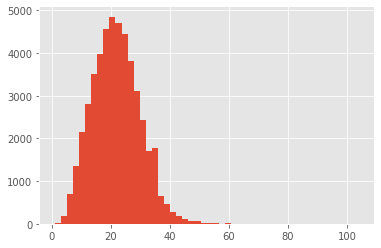

In [37]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [38]:
max_len = 60
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [39]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [40]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)

In [41]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [42]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [43]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
y = [to_categorical(i, num_classes=n_tags) for i in y]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)

In [44]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [45]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [46]:
model = Model(input, out)

In [47]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [48]:
history = model.fit(X_tr, np.array(y_tr), batch_size=32, epochs=5, validation_split=0.1, verbose=1)

/Users/subir/pythonenv/default/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 127s 3ms/step - loss: 0.1174 - accuracy: 0.9703 - val_loss: 0.0544 - val_accuracy: 0.9842
Epoch 2/5
38846/38846 [==============================] - 148s 4ms/step - loss: 0.0457 - accuracy: 0.9867 - val_loss: 0.0434 - val_accuracy: 0.9870
Epoch 3/5
38846/38846 [==============================] - 175s 5ms/step - loss: 0.0379 - accuracy: 0.9889 - val_loss: 0.0412 - val_accuracy: 0.9877
Epoch 4/5
38846/38846 [==============================] - 173s 4ms/step - loss: 0.0343 - accuracy: 0.9899 - val_loss: 0.0393 - val_accuracy: 0.9883
Epoch 5/5
38846/38846 [==============================] - 176s 5ms/step - loss: 0.0318 - accuracy: 0.9906 - val_loss: 0.0391 - val_accuracy: 0.9883


In [49]:
hist = pd.DataFrame(history.history)

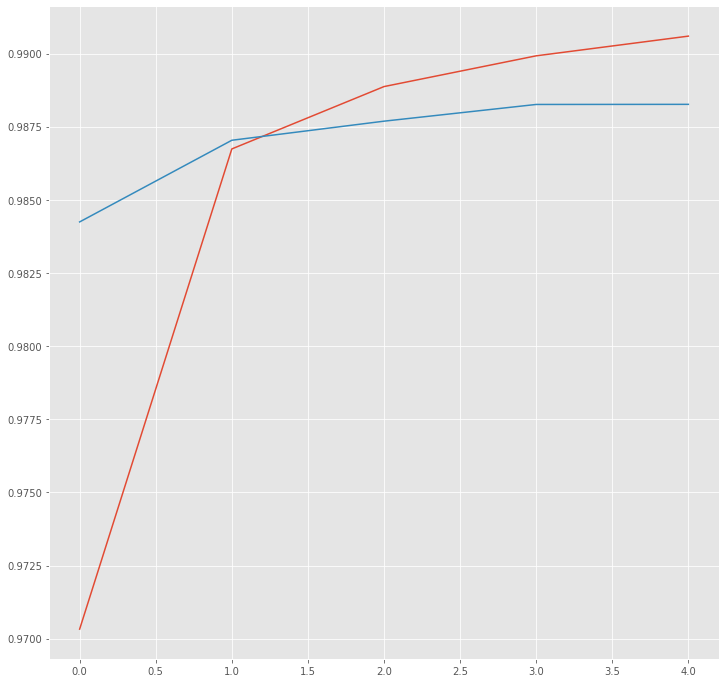

In [50]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

In [51]:
i = 2318
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, pred in zip(X_te[i], p[0]):
    print("{:15}: {}".format(words[w], tags[pred]))

Word            (True ): Pred
The            : O
coalition      : O
known          : O
as             : O
the            : O
Mutahida       : B-geo
Majlis-e-Amal  : I-org
has            : O
been           : O
holding        : O
rallies        : O
in             : O
Pakistan       : B-geo
since          : B-tim
December       : I-tim
,              : O
when           : O
President      : B-per
Pervez         : I-per
Musharraf      : I-per
reneged        : O
on             : O
a              : O
promise        : O
to             : O
quit           : O
his            : O
second         : O
job            : O
as             : O
army           : O
chief          : O
.              : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD 